In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

# Motion classification with time series using deep learning

> Classify between chaotic, rotational and librational motion using the evolution of the coordinates x and y in the Poincare map

In [ ]:
# parameters cell. Put here everything that could be needed if
# this notebook was called from outside, as an script
use_wandb = False # Whether to use or not wandb for experiment tracking
wandb_group = None # Whether to group this run in a wandb group
resampling_period = None # * Natural number. Set to None if no resampling is desired
labelling_method = "fli" # [fli, freq_ana]

In [ ]:
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    !pip install git+https://github.com/fastai/fastcore.git@master -q
    !pip install git+https://github.com/fastai/fastai2.git@master -q
    !pip install git+https://github.com/ai-fast-track/timeseries.git -q
    !pip install wandb -q

In [ ]:
from fastai2.basics import *
from timeseries.all import *
from mlchaos.all import *
import wandb
from fastai2.callback.wandb import *

In [ ]:
base_path = Path.home()

In [ ]:
if not use_wandb:
    os.environ['WANDB_MODE'] = 'dryrun' # run offline
    wandb.init(anonymous='allow', allow_val_change=True)
else:
    os.environ['WANDB_MODE'] = 'run' # run offline
    wandb.init(project='mlchaos', group=wandb_group)

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Loading the data

The data must be loaded as a `TSDataChaos` object, created from a pair (or a sequence of pairs) of files:
1. The first file of the pair contains the data of the Poincare map
2. The second file of the pair contains the index of the motion (0.0, 1.0 or 2.0). The column that contains the index is given as a parameter of this notebook

In [ ]:
wandb.config.labelling_method = labelling_method
index_cols = {
    "fli": 7,
    "freq_ana": 8
}

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
ds_path = base_path/'data'
fnames = [
    (ds_path/'eps=0.01/Poincare200pt.plt', ds_path/'eps=0.01/index200pt.plt'), 
    (ds_path/'eps=0.03/Poincare200pt.plt', ds_path/'eps=0.03/index200pt.plt'), 
    (ds_path/'eps=0.05/Poincare200pt.plt', ds_path/'eps=0.05/index200pt.plt')
]
wandb.config.fnames = fnames
data = TSDataChaos.from_poincare_and_index_files(fnames, 
                                                 index_col=index_cols[labelling_method])
data

wandb: Wandb version 0.10.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


TSDataChaos:
 Datasets names (concatenated): ['eps=0.01', 'eps=0.03', 'eps=0.05']
 Filenames:                     [(Path('/home/user/data/eps=0.01/Poincare200pt.plt'), Path('/home/user/data/eps=0.01/index200pt.plt')), (Path('/home/user/data/eps=0.03/Poincare200pt.plt'), Path('/home/user/data/eps=0.03/index200pt.plt')), (Path('/home/user/data/eps=0.05/Poincare200pt.plt'), Path('/home/user/data/eps=0.05/index200pt.plt'))]
 Data shape: (30603, 2, 201)
 Targets shape: (30603,)
 Nb Samples: 30603
 Nb Channels:           2
 Sequence Length: 201

Check the distribution of classes in the dataset

In [ ]:
np.unique(data.y, return_counts=True)

(array([-1.,  0.,  1.,  2.]), array([ 1562,  7438, 12768,  8835]))

The class -1 represents uncertainty in the FLI-based classication. If desired, we can remove that class from the dataset, by changing the flag `add_uncertainty_class` in the cell below. 

In [ ]:
wandb.config.add_uncertainty_class = False

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
if not wandb.config.add_uncertainty_class:
    data.x = data.x[data.y != -1]
    data.y = data.y[data.y != -1]
data

TSDataChaos:
 Datasets names (concatenated): ['eps=0', 'eps=0', 'eps=0']
 Filenames:                     [(Path('/home/user/data/eps=0.01/Poincare200pt.plt'), Path('/home/user/data/eps=0.01/index200pt.plt')), (Path('/home/user/data/eps=0.03/Poincare200pt.plt'), Path('/home/user/data/eps=0.03/index200pt.plt')), (Path('/home/user/data/eps=0.05/Poincare200pt.plt'), Path('/home/user/data/eps=0.05/index200pt.plt'))]
 Data shape: (29041, 2, 201)
 Targets shape: (29041,)
 Nb Samples: 29041
 Nb Channels:           2
 Sequence Length: 201

The data can be resampled to a lower frequency if desired. The reason why this is interesting is because being able to produce an accurate classification without the need of many data points per time series makes this procedure applicable to observational data. As an example, choosing `resampling_period` equals to 2 means that the time series will be resampled in a way that we take one point every 2 points of the original data.  

In [ ]:
wandb.config.resampling_period = resampling_period

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
if wandb.config.resampling_period is not None:
    data.x = data.x[:,:,::wandb.config.resampling_period]
    print(data)

## Splitting the data into training and validation

By default we use 80% random items from the data as training and 20% as validation

In [ ]:
splits = RandomSplitter()(range_of(data.get_items()))
#splits = (range_of(data.get_items()), range_of(data.get_items())) # Valid = train

##  Creating a `Datasets` object

In [ ]:
lbl_dict = dict([
    ('-1.0', 'uncertain'),
    ('0.0', 'chaotic'),   
    ('1.0', 'rotational'),   
    ('2.0', 'librational')]
)

In [ ]:
tfms = [[ItemGetter(0), ToTensorTS(), ToTensorMotion()], # x transforms
        [ItemGetter(1), lbl_dict.get, Categorize()]] # y transforms

In [ ]:
%%time
ds = Datasets(items=data.get_items(), tfms=tfms, splits=splits)

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


Show one element of the dataset. By default, the `show` method will display the item as a Poincare map.

rotational


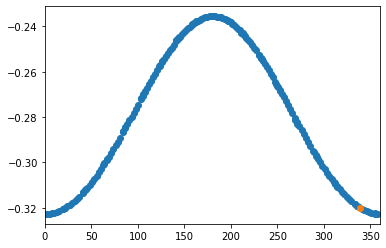

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1))

It can be useful to visualize the motions with he same y limits. We take them from the training set

In [ ]:
ylim = [data.x[:, 1].min(), data.x[:, 1].max()]
ylim

[-0.7248967745980109, 1.72489677459802]

rotational


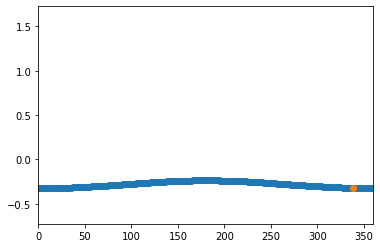

In [ ]:
ax = show_at(ds, 1003, figsize=(1,1), ylim=ylim)

## Creating a `Dataloaders` object using the `Datasets` object

In [ ]:
bs = 256                            
# Normalize at batch time
tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = []

dls = ds.dataloaders(bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

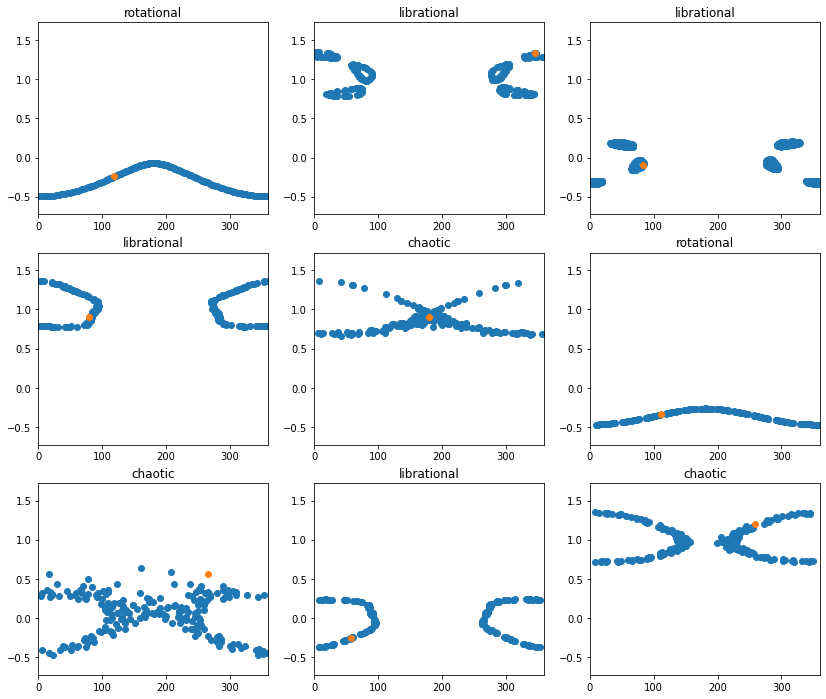

In [ ]:
dls.show_batch(max_n=9, ylim=ylim, return_fig=False)

In [ ]:
xb, yb = dls.one_batch()
print(xb[0].mean(axis=1), xb[0].std(axis=1))

tensor([ 1.8075e+02, -9.0971e-03], device='cuda:0') tensor([101.6391,   0.2427], device='cuda:0')


## Training a model 

In [ ]:
# Number of channels
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(2, 3)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
# model

### Creating a Learner object

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner    
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, 
                loss_func=loss_func, metrics=accuracy)

# print(learn.summary())

(0.025118863582611083, 0.0004786300996784121)

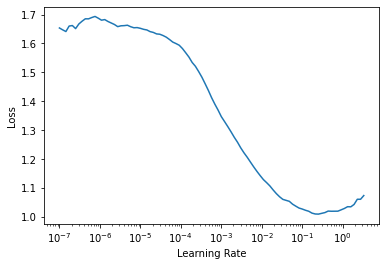

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch,train_loss,valid_loss,accuracy,time
0,0.592150,0.394000,0.955923,00:24
1,0.381206,0.335705,0.983643,00:23
2,0.343394,0.330807,0.986915,00:24
3,0.322156,0.311998,0.993285,00:23
4,0.314060,0.309576,0.992769,00:24
5,0.306146,0.309082,0.993629,00:24
6,0.302272,0.303981,0.993974,00:23
7,0.297944,0.302603,0.995696,00:24
8,0.295278,0.301777,0.995523,00:24
9,0.293814,0.301710,0.995351,00:24


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


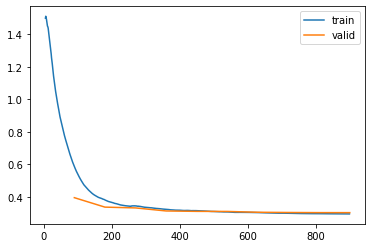

In [ ]:
learn.fit_one_cycle(10, lr_max=3e-3, cbs=WandbCallback(log_preds=False))
learn.recorder.plot_loss()

## Showing results

### Results for random items in the validation set 

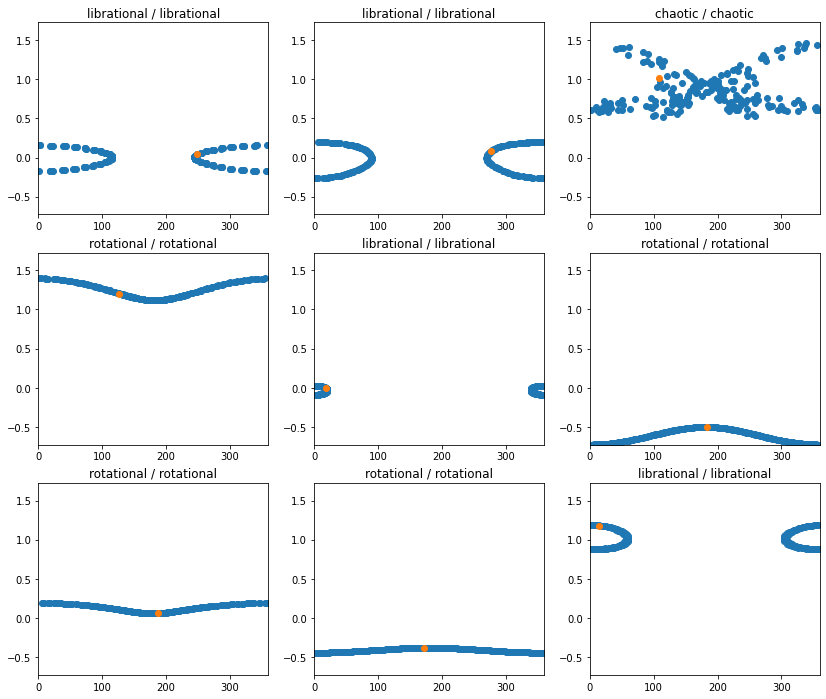

In [ ]:
learn.show_results(max_n=9, ylim=ylim)

### Showing the confusion matrix

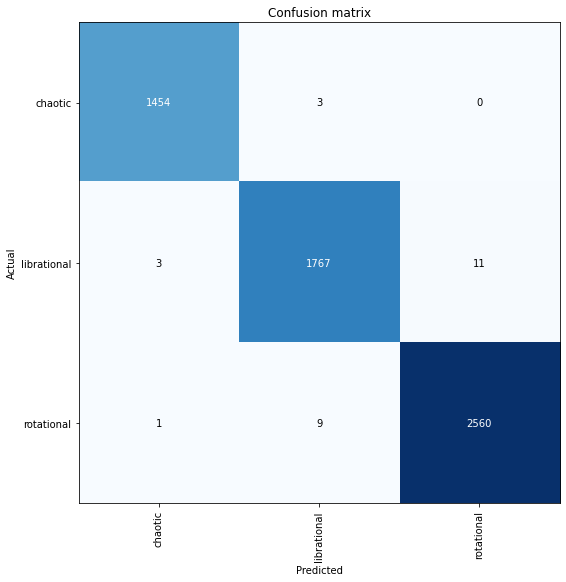

In [ ]:
interp = ClassificationInterpretationAugmented.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,8))

### Smallest errors

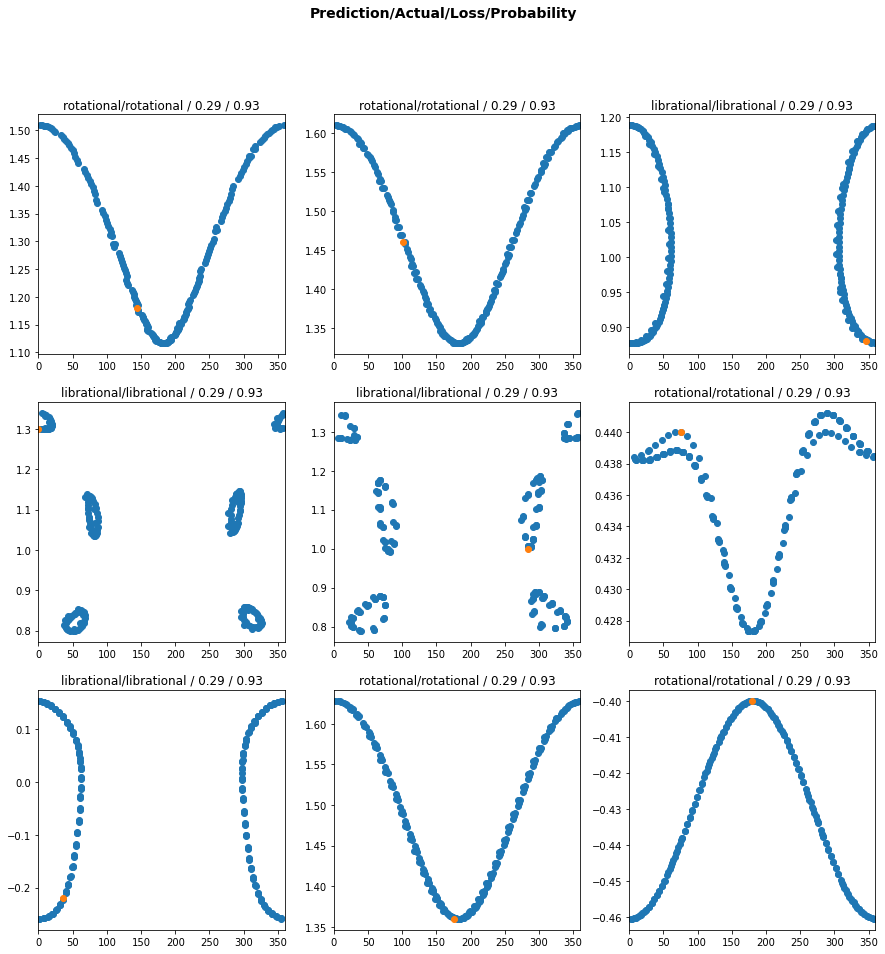

In [ ]:
interp.plot_top_losses(k=9, figsize=(15, 15), largest=False)

### Largest errores

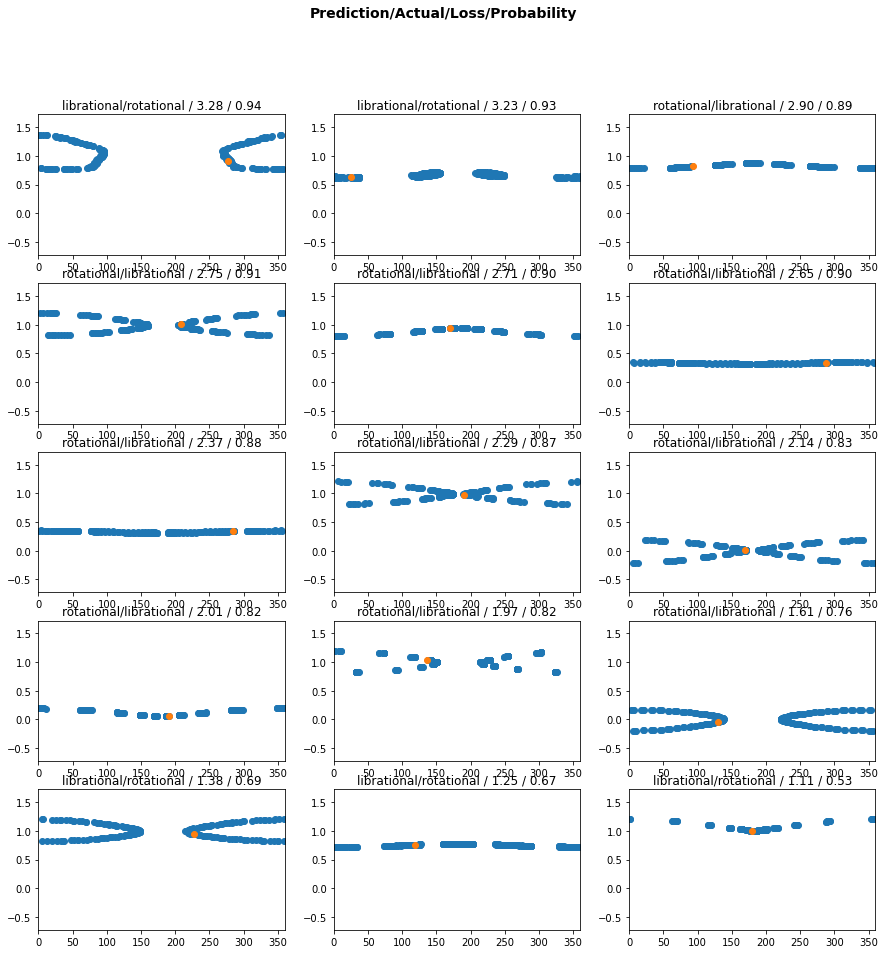

In [ ]:
interp.plot_top_losses(k=15, figsize=(15, 15), nrows=5, largest=True, ylim=ylim)

## Types of errors

It is also interesting to display separately errors of different type. There are a number of `c*(c-1)` possible type of errors, where `c` is the number of classes in the data

In [ ]:
print(interp.top_losses(k=3, largest=False, predicted='chaotic', actual='chaotic'))
print(interp.top_losses(k=3, largest=False, predicted='rotational', actual='rotational'))
print(interp.top_losses(k=3, largest=False, predicted='librational', actual='librational'))

(tensor([0.2911, 0.2911, 0.2911]), tensor([3013, 5473, 1556]))
(tensor([0.2911, 0.2911, 0.2911]), tensor([4488, 3813, 4316]))
(tensor([0.2911, 0.2911, 0.2911]), tensor([1747, 4451, 3834]))


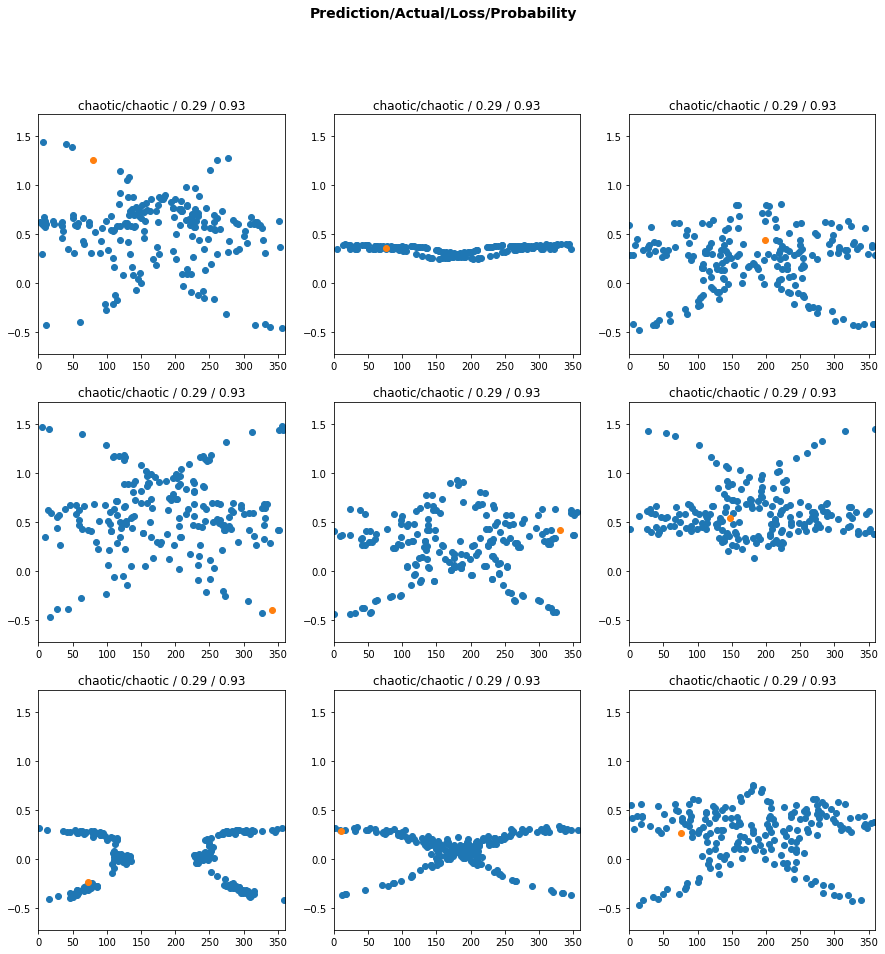

In [ ]:
predicted = 'chaotic'
actual = 'chaotic'
n_errors = interp.confusion_matrix()[interp.vocab.o2i[predicted], 
                                     interp.vocab.o2i[actual]]
interp.plot_top_losses(k=min(n_errors, 9), figsize=(15, 15), 
                       largest=False, ylim=ylim, 
                       predicted=predicted, 
                       actual=actual)

## Explaining the model predictions through class activation maps

We will use the function `show_cam` from the library `timeseries` to plot the Class Activation Maps (CAMs)

In [ ]:
?show_cam

Signature:
show_cam(
    batch,
    model,
    layer=5,
    func_cam=<function cam_acts at 0x7f941465e620>,
    reduction='mean',
    force_scale=True,
    scale_range=(0, 1),
    cmap='Spectral_r',
    linewidth=4,
    linestyles='solid',
    alpha=1.0,
    scatter=False,
    i2o=<function noop at 0x7f9444a77598>,
    figsize=None,
    multi_fig=False,
    confidence=None,
    savefig=None,
    linewidths=None,
    colors=None,
    antialiaseds=None,
    offsets=None,
    transOffset=None,
    norm=None,
    pickradius=5,
    zorder=2,
    facecolors='none',
)
Docstring: Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the         scaled CAM values. The time series are plot either on a single figure or on a multiple figures
File:      ~/lib/timeseries/timeseries/cam.py
Type:      function


We need a function `i2o` that, given an encoded y, i.e, an instance of `TensorCategory`, return the label associated to that index, i.e., we need to decode the labels.

In [ ]:
def i2o(y):
    return dls.tfms[1].decode(y)

In [ ]:
print(i2o(TensorCategory(0)))
print(i2o(TensorCategory(1)))
print(i2o(TensorCategory(2)))

chaotic
librational
rotational


## Inference on a new test set

Now let's see how the trained behaves with a completely unseen set of data. First we have to load the Poincare maps that comprise the test set

Compute the predicted labels using the library `fastinference`. It is faster than the original `fastai` implementation.

In [ ]:
#old_get_preds = learn.get_preds
#from fastinference.inference import *

In [ ]:
test_base_path = base_path/'data/eps=0.02_pert_pend_model_2'

In [ ]:
fnames_test = (test_base_path/'Poincare200pt.plt', 
               test_base_path/'index200pt.plt')
test_data = TSDataChaos.from_poincare_and_index_files(fnames_test)
test_data

TSDataChaos:
 Datasets names (concatenated): ['eps=0']
 Filenames:                     [(Path('/home/user/data/eps=0.02_pert_pend_model_2/Poincare200pt.plt'), Path('/home/user/data/eps=0.02_pert_pend_model_2/index200pt.plt'))]
 Data shape: (10201, 2, 201)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 201

In [ ]:
if not wandb.config.add_uncertainty_class:
    test_data.x = test_data.x[test_data.y != -1]
    test_data.y = test_data.y[test_data.y != -1]
test_data

TSDataChaos:
 Datasets names (concatenated): ['eps=0']
 Filenames:                     [(Path('/home/user/data/eps=0.02_pert_pend_model_2/Poincare200pt.plt'), Path('/home/user/data/eps=0.02_pert_pend_model_2/index200pt.plt'))]
 Data shape: (9699, 2, 201)
 Targets shape: (9699,)
 Nb Samples: 9699
 Nb Channels:           2
 Sequence Length: 201

Create a dataloader from the test items previously loaded. This will apply all the transformations used in our training and validation set (e.g. normalization) to the test data

In [ ]:
test_dl = learn.dls.test_dl(test_data.get_items(), with_labels=True)
test_dl.n

9699

In [ ]:
preds, targs, preds_decoded = learn.get_preds(dl=test_dl, with_decoded=True)
preds.__len__()

9699

Compute metrics (validation loss and accuracy) on the test set.

In [ ]:
test_metrics = learn.validate(dl=test_dl)
test_metrics

(#2) [0.7197743654251099,0.7502835392951965]

Show also trhe confusion matrix for this test set

In [ ]:
# learn.get_preds = old_get_preds
interp_test = ClassificationInterpretationAugmented.from_learner(learn, 
                                                                 dl=test_dl)

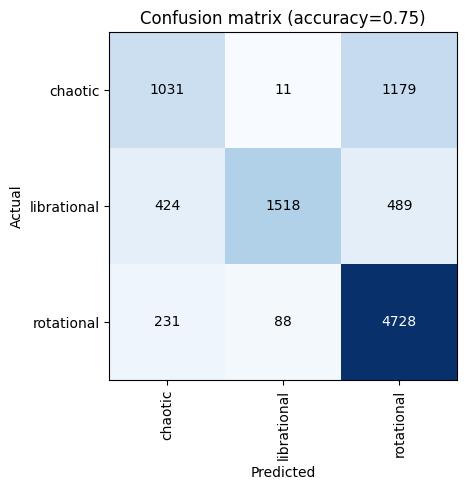

In [ ]:
interp_test.plot_confusion_matrix(
    title=f'Confusion matrix (accuracy={round(test_metrics[1], 2)})',
)
plt.savefig(test_base_path/f'confusion_matrix_{test_base_path.name}.png')

Show the FLI plot to get a sense of the quality of the predictions

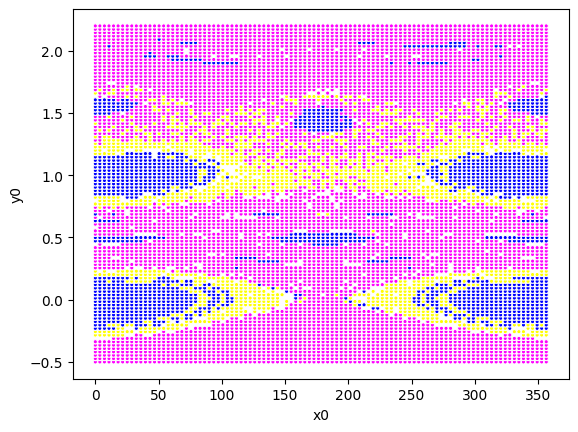

In [ ]:
ml_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in preds_decoded], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

In [ ]:
ml_map.figure.savefig(test_base_path/f'ml_map_{test_base_path.name}.eps', 
                      transparent=True, format='.eps')

Now show the same plot for the true labels given by the FLI-based classification

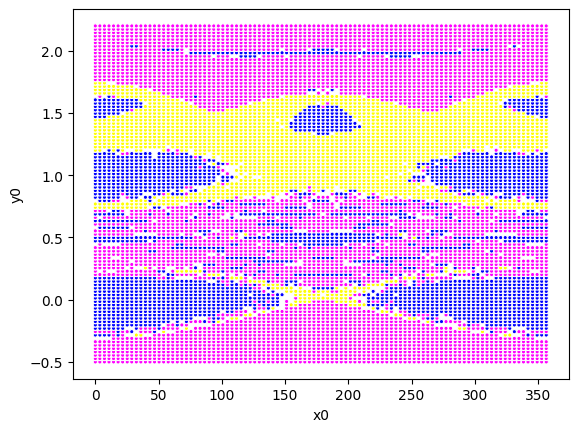

In [ ]:
true_map = show_fli_plot(test_data.x, 
                    [dls.tfms[1].decode(y) for y in targs], 
                    legend=None,
                    palette=dict(
                        chaotic='yellow', 
                        librational='blue', 
                        rotational='magenta'))

In [ ]:
true_map.figure.savefig(test_base_path/f'true_map_{test_base_path.name}.eps', 
                        transparent=True, format='.eps')